In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # Import for custom grid layout
import pickle
from pathlib import Path
from config import dir_config
from src.decision_models import *

In [3]:
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)

## Helper functions

In [4]:
def plot_ddm_fit(model, data, stimulus, result, enable_leak=True, enable_time_dependence=True):
    # Initialize the simulator


    for idx_prior, prior in enumerate(["equal", "unequal"]):
        ddm = DriftDiffusionSimulator(leak=enable_leak, time_dependence=enable_time_dependence)
        prior_mask = data["prior_block"] == prior
        # Map params into simulator
        for name, value in zip(model.all_params, result.x):
            if name.endswith("_1") and idx_prior == 0:
                base_name = name[:-2]
                setattr(ddm, base_name, value)
            elif name.endswith("_2") and idx_prior == 1:
                base_name = name[:-2]
                setattr(ddm, base_name, value)
            else:
                setattr(ddm, name, value)

        # Simulate trials
        rt, choice, dv = ddm.simulate_trials(stimulus[prior_mask])

        # Create DataFrame of simulated data
        model_sim = pd.DataFrame(
            {
                "signed_coherence": data[prior_mask].signed_coherence,
                "choice": choice.flatten(),
                "rt": rt.flatten(),
            }
        )

        # Get psychometric and chronometric data for both real and simulated data
        x_data, y_data = get_psychometric_data(data[prior_mask])
        _, rt_median, rt_mean, rt_sd, _ = get_chronometric_data(data[prior_mask])
        x_model, y_model = get_psychometric_data(model_sim)
        _, rt_median_model, rt_mean_model, rt_sd_model, _ = get_chronometric_data(model_sim)

        # Plotting
        fig = plt.figure(figsize=(12, 10))
        gs = gridspec.GridSpec(2, 2)

        # Psychometric plot (proportion choice)
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(x_data, y_data, "o", color="k", label="data")
        ax1.plot(x_model, y_model, "o", color="b", label="model")
        ax1.set_ylim(-0.1, 1.1)
        ax1.legend()

        # Chronometric plot (RT means)
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(x_data, rt_median, "o", color="k", label="data")
        ax2.fill_between(x_data, rt_mean - rt_sd, rt_mean + rt_sd, color="k", alpha=0.2)
        ax2.fill_between(x_model, rt_mean_model - rt_sd_model, rt_mean_model + rt_sd_model, color="b", alpha=0.2)
        ax2.plot(x_model, rt_median_model, "o", color="b", label="model")
        ax2.legend()

        ax3 = fig.add_subplot(gs[1, :])
        ax3.plot(dv.T, color="k", alpha=0.1)

        plt.tight_layout()
        plt.show()

        # Print proportion of invalid trials (NaN choices)
        print("Proportion of invalid trials:", np.mean(np.isnan(choice)))

    # return model_sim, ddm


## import data

In [5]:
with open(Path(processed_dir, 'sessions_metadata.csv'), 'r') as f:
    session_metadata = pd.read_csv(f)

## prepare data

In [6]:

# Pre-allocate lists for session data
behavior_df = pd.DataFrame(columns=["session_id", "prior_direction", "GP_trial_num", "prob_toRF", "signed_coherence", "target", "choice", "outcome","response_time"])


# Process each session
for _, session_row in session_metadata.iterrows():

    session_id = session_row["session_id"]
    prior_direction = "L" if (session_row["prior_direction"] == "toRF" and session_row["RF_side"] == "L") or (session_row["prior_direction"] == "awayRF" and session_row["RF_side"] == "R") else "R"

    # Read trial data for each session
    trial_data = pd.read_csv(Path(compiled_dir, session_id, f"{session_id}_trial.csv"), index_col=None)
    GP_trial_data = trial_data[trial_data.task_type == 1].reset_index()


    # Get valid indices based on outcomes
    valid_idx = np.where((GP_trial_data.outcome >= 0) & (~np.isnan(GP_trial_data.reaction_time.values)))[0]

    coherence = GP_trial_data.coherence.values[valid_idx]
    target = GP_trial_data.target.values[valid_idx].astype(int)
    choices = GP_trial_data.choice.values[valid_idx].astype(int)
    outcomes = GP_trial_data.outcome.values[valid_idx].astype(int)

    if session_row["RF_side"] == "L": # flip target and choice to L/R as 0/1
        target = 1 - target
        choices = 1 - choices

    signed_coherence = coherence * (target * 2 - 1)
    GP_trial_num = np.array(GP_trial_data.trial_number)[valid_idx]
    prob_toRF = np.array(GP_trial_data.prob_toRF)[valid_idx]

    # Check for NaNs or missing values
    if np.isnan(coherence).any():
        print(f"Warning: NaNs found in coherence for session {session_id}")
    if np.isnan(GP_trial_data.reaction_time.values[valid_idx]).any():
        print(f"Warning: NaNs found in reaction_time for session {session_id}")
    if pd.isnull(target).any():
        print(f"Warning: Missing target values for session {session_id}")
    if pd.isnull(choices).any():
        print(f"Warning: Missing choice values for session {session_id}")
    if pd.isnull(outcomes).any():
        print(f"Warning: Missing outcome values for session {session_id}")

    behavior_df = pd.concat([behavior_df, pd.DataFrame({
        "session_id": session_id,
        "prior_direction": prior_direction,
        "GP_trial_num": GP_trial_num,
        "prob_toRF": prob_toRF,
        "signed_coherence": signed_coherence, # range[-100,100]
        "target": target,
        "choice": choices,
        "outcome": outcomes,
        "rt": GP_trial_data.reaction_time.values[valid_idx]/1000 # in sec
    })], ignore_index=True)

behavior_df['prior_block'] = np.where(behavior_df['prob_toRF'] == 50, 'equal', 'unequal')


In [7]:
optimizer_options = {
    'maxiter': 1000,
    'maxls': 50,
    'ftol': 1e-6,
    'gtol': 1e-4,
    'disp': True
}


In [ ]:
models, results = [], []
enable_leak=True
enable_time_dependence=True
for session_id in np.unique(behavior_df.session_id):
    print(f"Fitting session {session_id}")
    data = behavior_df[(behavior_df.session_id == session_id)]
    data = data[["signed_coherence", "choice", "rt","prior_block"]].reset_index(drop=True)
    data['choice'] = data['choice'].astype(int)

    # # Get stimulus length
    stimulus_length = int(np.max(data["rt"])*1000)
    stimulus = np.tile(data["signed_coherence"].to_numpy().reshape(-1, 1), (1, stimulus_length))/100 # range[-1,1]


    model = DecisionModel(enable_leak=enable_leak, enable_time_dependence=enable_time_dependence, device="cuda")

    result = model.fit(data, stimulus, optimizer_options=optimizer_options)

    models.append(model)
    results.append(result)


Fitting session 210126_GP_JP
Optimization terminated successfully.
         Current function value: 879.530798
         Iterations: 3
         Function evaluations: 634
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23738D+03    |proj g|=  7.39107D+00

At iterate    1    f=  7.23157D+02    |proj g|=  7.39107D+00

At iterate    2    f=  1.29387D+03    |proj g|=  1.16089D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      2     26     12     0     0   1.161D+01   1.294


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [15]:
for model,result in zip(models,results):
    for idx, key in enumerate(model.all_params):
        print(f"{key}: {result.x[idx]:.3f}, bound: {model.all_params[key][1]}")
    print(f"Loss fn: {result.fun}\n")


ndt: 0.174, bound: (0.05, 0.3)
drift_gain: 12.609, bound: (1.0, 20.0)
variance: 2.479, bound: (0.1, 5.0)
a_1: 3.931, bound: (0.5, 5.0)
z_1: 0.549, bound: (0.1, 0.9)
drift_offset_1: -0.478, bound: (-5.0, 5.0)
a_2: 3.938, bound: (0.5, 5.0)
z_2: 0.364, bound: (0.1, 0.9)
drift_offset_2: -1.289, bound: (-5.0, 5.0)
leak_rate: 0.838, bound: (0.0, 1.0)
time_constant: 0.003, bound: (0.0, 0.1)
Loss fn: 1293.872843142085



In [14]:
import pickle
with open(Path(processed_dir, 'ddm_session_1_fit.pkl'), 'wb') as f:
    pickle.dump({'models': models, 'results': results}, f)

Fitting session 210126_GP_JP


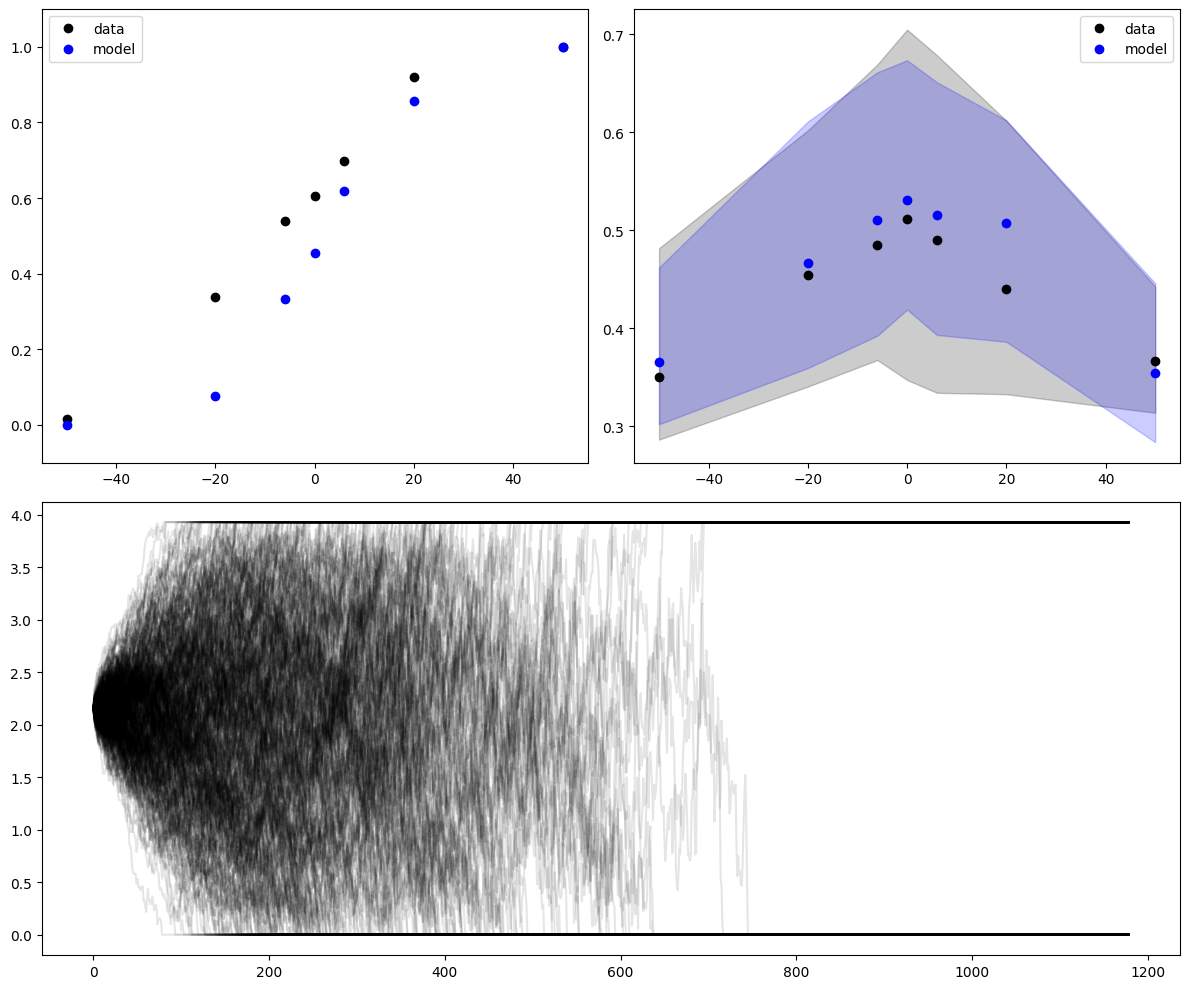

Proportion of invalid trials: 0.0


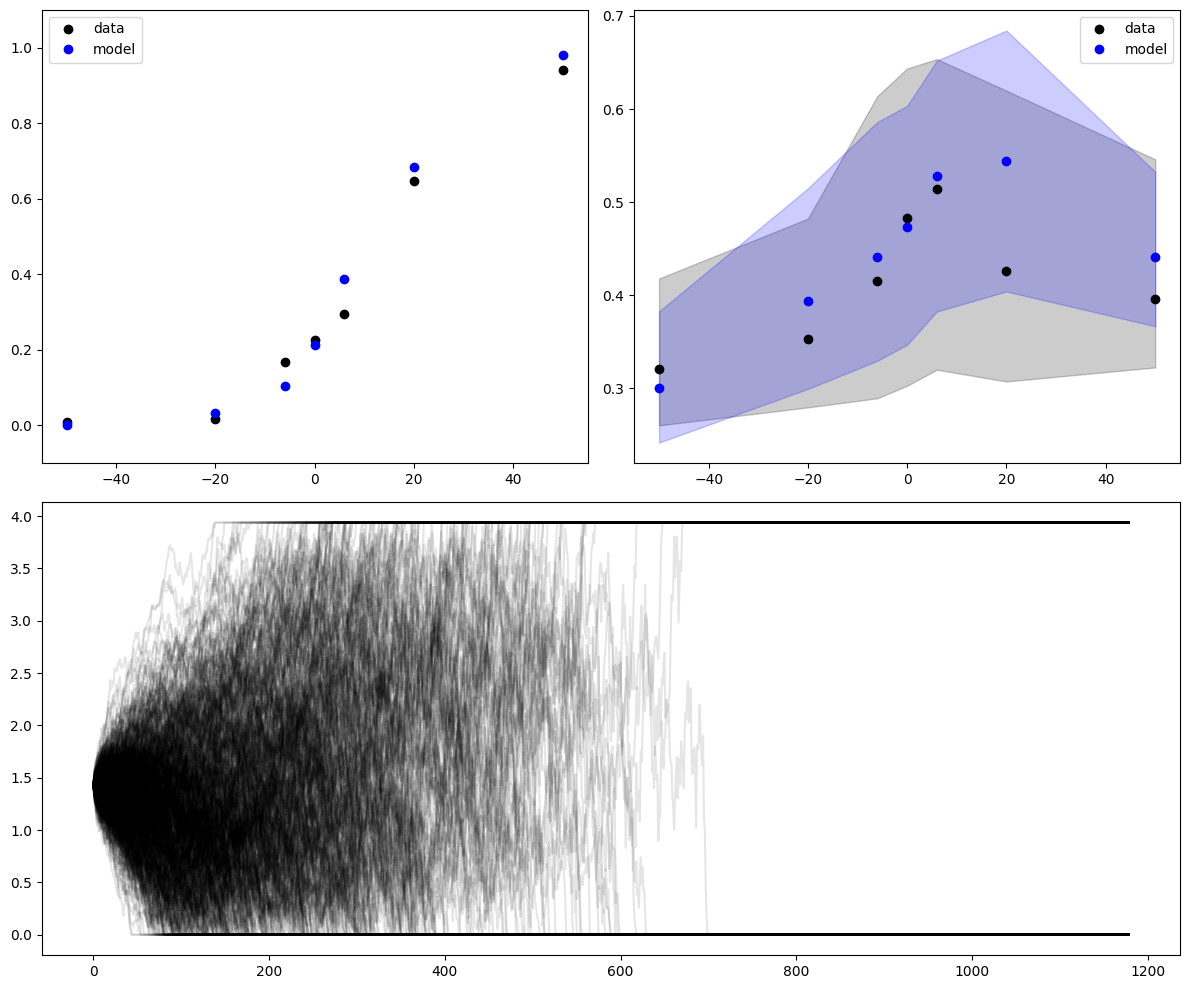

Proportion of invalid trials: 0.0


In [13]:
for session_idx, session in enumerate(np.unique(behavior_df.session_id)):
    print(f"Fitting session {session}")
    data = behavior_df[(behavior_df.session_id == session)]
    data = data[["signed_coherence", "choice", "rt", "prior_block"]]
    data['choice'] = data['choice'].astype(int)

    # # Get stimulus length
    stimulus_length = int(np.max(data["rt"])*1000)
    stimulus = np.tile(data["signed_coherence"].to_numpy().reshape(-1, 1), (1, stimulus_length))/100 # range[-1,1]
    plot_ddm_fit(models[session_idx], data, stimulus, results[session_idx], enable_leak=enable_leak, enable_time_dependence=enable_time_dependence)


    break